In [1]:
import os, sys
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
sys.path.insert(0, parentdir) 

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

import numpy as np
import scipy
from scipy.integrate import odeint, DOP853, solve_ivp
from scipy.stats import special_ortho_group
from scipy.linalg import qr
import nolds

import seaborn as sns
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
from analysis_functions import find_analytic_fixed_points

def ReLU(x):
    return np.where(x<0,0,x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def linear_ode(t,x,W,b):
    return np.dot(W,x)+b 

def relu_ode(t,x,W,b):
    return ReLU(np.dot(W,x)+b) - x 

def sigmoid_ode(t,x,W,b):
    return sigmoid(np.dot(W,x)+b) 

def tanh_ode(t,x,W,b,tau):
    return (-x + np.dot(W,np.tanh(x))+b)/tau

def tanh_adj_ode(t,x,W,tau,x_solved):
    return np.dot(-(-1 + np.dot(W.T,1/np.cosh(x_solved(t))**2))/tau, x)

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### One fixed point

In [28]:
N_1 = 5
# A = np.random.normal(0,.1,(N,N))
b = np.random.normal(0,.1,N_1)

A = -.5*np.eye(N_1)
A += np.random.normal(0,.1,(N_1,N_1))

In [29]:
t0, t1 = 0, 20
t = np.linspace(t0,t1,101)
y0 = np.random.normal(0,1,N_1).squeeze()

In [30]:
sol = solve_ivp(linear_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([A,b]), dense_output=True)

sols_1 = np.zeros((10,N_1,t.shape[0]))
for i in range(10):
    y0 = np.random.normal(0,1,(N_1))
    sol = solve_ivp(linear_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([A,b]), dense_output=True)
    sols_1[i,...] = sol.sol(t)

sol_adjoint_1 = solve_ivp(linear_ode, t_span=[t1, t0], t_eval=t[::-1], y0=sol.sol(t)[:,-1], args=([-A.T,0]), dense_output=True).sol(t)

eigenvalues, _ = np.linalg.eig(A)

lyap_spec_1 = nolds.lyap_e(sol.sol(t)[0,:], emb_dim=5,  matrix_dim=N_1)

sol_1 = sol.sol(t)
lyap_spec_1

array([-0.03997987, -0.05977721, -0.09756774, -0.30104256, -0.73538   ],
      dtype=float32)

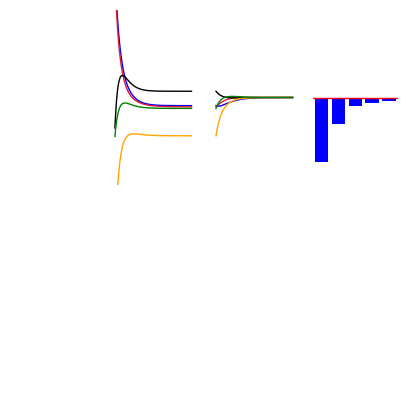

In [31]:
fig, axs = plt.subplots(2, 4, figsize=(5, 5), sharex=False, sharey=True)
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];
# for ax in [axs[0,0],axs[0,1]]:
#     for label in ax.get_yticklabels():
#         label.set_visible(False)
# [axi.yaxis.set_tick_params(labelright='on', labelleft='off') for axi in axs.ravel()];

axs[0,1].plot(sol_1[:,:].T)
axs[0,2].plot(sol_adjoint_1[:,::-1].T)
axs[0,3].bar(range(N_1), lyap_spec_1[::-1])
axs[0,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_1-0.5),ylim=(-1,1));
axs[0,3].set_yticks([0],[0])
# axs[0,0].yaxis.tick_right()

### Two fixed points

In [32]:
N_2 =3
W = np.array([[0.2,-1,0],[-1,0.1,0],[0,0,-1]])
b = np.array([1,1,1])

In [33]:

def fp2_ode(t,x,W,b):
    return [x[0]-x[1], -x[0]-x[1], x[2]]

# from analysis_functions import find_analytic_fixed_points
find_analytic_fixed_points(W, b, 0*W, [0,0,0], tol=10**-4)

([array([1.25, 0.  , 0.5 ]),
  array([0.        , 1.11111111, 0.5       ]),
  array([0.35714286, 0.71428571, 0.5       ])],
 [1, 1, 0],
 [0, 0, 1])

In [37]:
y0 = np.array([0.1,.2,.3])

sol = solve_ivp(relu_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([W,b]), dense_output=True)

sol_adjoint_2 = solve_ivp(relu_ode, t_span=[t1, t0], t_eval=t[::-1], y0=sol.sol(t)[:,-1], args=([-W.T,0]), dense_output=True).sol(t)

J = 1/np.cosh(W)
eigenvalues, _ = np.linalg.eig(W)

lyap_spec_2 = nolds.lyap_e(sol.sol(t)[1,:], emb_dim=N_2,  matrix_dim=N_2)
lyap_spec_2

array([-0.08996105, -0.11961539, -0.38471696], dtype=float32)

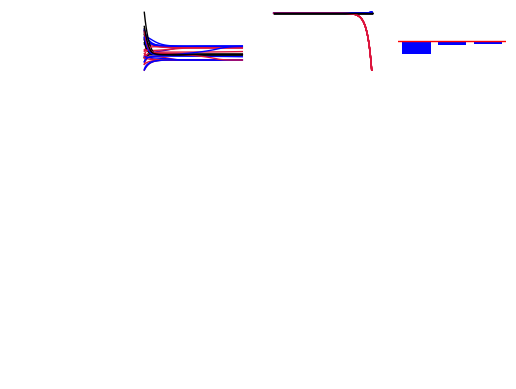

In [45]:
fig, axs = plt.subplots(5, 4)
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k']) for axi in axs.ravel()];

sols_2 = np.zeros((10,N_2,t.shape[0]))

for i in range(10):
    y0 = np.array([1,0,2])+np.random.normal(0,1,(3))
    sol = solve_ivp(relu_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([W,b]), dense_output=True)
    eigenvalues, _ = np.linalg.eig(W)
    axs[0,1].plot(sol.sol(t)[:,:].T)
    axs[0,2].plot(sol_adjoint.sol(t)[:,::-1].T)
    sols_2[i,...] = sol.sol(t)
sol_adjoint_line = solve_ivp(relu_ode, t_span=[t1, t0], t_eval=t[::-1], y0=y0, args=([-W.T,0]), dense_output=True).sol(t)

axs[0,3].bar(range(N_2), lyap_spec_2[::-1])
axs[0,3].plot((-N_2,2*N_2), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_2-0.5),ylim=(-1,1));

### Line attractor

In [10]:
N =3
W = np.array([[0.,-1,0],[-1,0.,0],[0,0,-2]])
b = np.array([1,1,1])

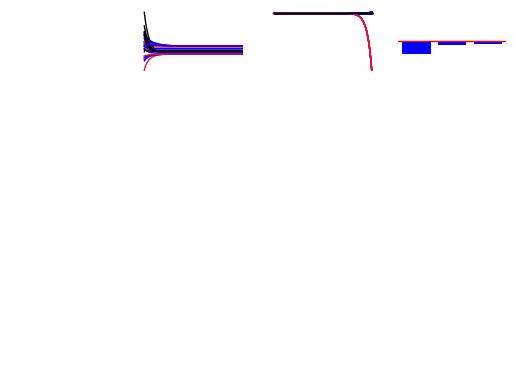

In [11]:
fig, axs = plt.subplots(5, 4)
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k']) for axi in axs.ravel()];

sols_line = np.zeros((10,N_2,t.shape[0]))

for i in range(10):
    y0 = np.array([1,0,2])+np.random.normal(0,1,(3))
    sol = solve_ivp(relu_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([W,b]), dense_output=True)
    eigenvalues, _ = np.linalg.eig(W)
    axs[0,1].plot(sol.sol(t)[:,:].T)
    axs[0,2].plot(sol_adjoint.sol(t)[:,::-1].T)
    sols_line[i,...] = sol.sol(t)
sol_adjoint_line = solve_ivp(relu_ode, t_span=[t1, t0], t_eval=t[::-1], y0=y0, args=([-W.T,0]), dense_output=True)
lyap_spec_line = nolds.lyap_e(sol[1,:], emb_dim=N_2,  matrix_dim=N_2, tau=tau)
axs[0,3].bar(range(N_2), lyap_spec_line[::-1])
axs[0,3].plot((-N_2,2*N_2), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_2-0.5),ylim=(-1,1));

### Chaos

In [12]:
def lorenz_ode(t,x,sigma,beta,rho):
    return [sigma*(x[1]-x[0]), x[0]*(rho-x[2])-x[1], x[0]*x[1]-beta*x[2]]
sigma = 10
beta = 8/3
rho = 28

In [13]:
# W_chaos_10 = W
# W = W_chaos_20
N_chaos = 200
g = 1.8
tau = 10/1000.
mask = np.where(np.random.random((N_chaos,N_chaos))>0.9,1,0)
W = np.dot(np.random.normal(0,g/np.sqrt(N_chaos),(N_chaos,N_chaos)), mask)
eigenvalues, _ = np.linalg.eig(W-np.eye(N_chaos))
b = np.ones(N_chaos)*0

In [14]:
# np.savetxt("W_200_chaos.csv", W, delimiter=",")

In [15]:
# W_lim = W
# W_lim = np.array([[ 0.16164438,  0.00206552, -0.09377584, -0.91051613,  0.49639557,
#         -0.10887785,  0.04867246,  0.07931177, -0.62945739, -0.57760051],
#        [-0.17721903, -0.18278902, -0.12953674, -0.15915309, -0.5485906 ,
#          0.06720053, -0.25651192,  0.12299908,  0.21034737,  0.31858925],
#        [ 0.16104494, -0.17780969,  0.60176152,  0.58565899, -0.23113556,
#         -0.03407021,  0.64289483,  0.37218597, -0.10222395,  0.3038166 ],
#        [-0.24554898, -0.70105061,  0.11842328, -0.25218331,  0.23622908,
#          0.02799082, -0.1248221 ,  0.26116853,  0.00724871, -0.35039401],
#        [ 0.01581696, -0.34773737, -0.3716975 , -0.2173326 ,  0.80242094,
#         -0.59597735, -0.4093876 , -0.49191879,  0.15427742, -1.05414341],
#        [-0.38906397, -0.05193829,  0.29205791, -0.23239994, -0.61542266,
#          0.298615  ,  0.05705484,  0.00210168, -0.02126095, -0.27576007],
#        [ 0.3629926 , -0.25514185, -0.18384151, -0.10251267,  0.23733547,
#          0.67602529,  0.30568502,  0.09855831,  0.2151137 , -0.04379499],
#        [-0.17072471,  0.27999845,  0.21077721,  0.31723937,  0.27757997,
#         -0.56634436,  0.51660594, -0.11765302,  0.32894467,  0.1010942 ],
#        [ 0.1323852 , -0.49654473,  0.70217202, -0.12635564,  0.17965325,
#          0.42268553,  0.18265644,  0.1926625 ,  0.08002335, -0.42905903],
#        [ 0.67093683, -0.06877035,  0.59079334,  0.04206101, -0.28330778,
#         -0.12045777, -0.50425259,  0.04005931,  0.0789644 , -0.25332975]])

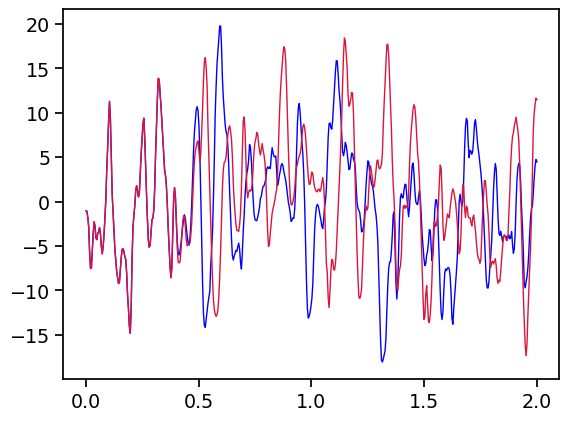

In [16]:
fig, ax = plt.subplots(1, 1)
ax.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g'])

t0, t1 = 0, 2
t_chaos = np.linspace(t0,t1,500)
y0_0 = np.random.normal(0,2,N_chaos).squeeze()
for i in range(2):
    y0 = y0_0 + np.random.normal(0,1e-10,N_chaos).squeeze()
    sol = solve_ivp(tanh_ode, t_span=[t0, t1], t_eval=t_chaos, y0=y0, args=([W,b,tau]), dense_output=True)
    ax.plot(t_chaos, sol.sol(t_chaos)[:1,:].T)
y0_adj = np.random.normal(0,1,N_chaos).squeeze()
sol_chaos = sol.sol(t_chaos)
x_solved = sol.sol
sol_adjoint_chaos = solve_ivp(tanh_adj_ode, t_span=[t1, t0], t_eval=t_chaos[::-1], y0=y0_adj, args=([W,tau,x_solved]), dense_output=True).sol(t_chaos)
lyap_spec_chaos = nolds.lyap_e(sol_chaos[1,:], emb_dim=N_chaos,  matrix_dim=N_chaos, tau=tau)

In [17]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

Text(0.5, 0, 'Spectrum')

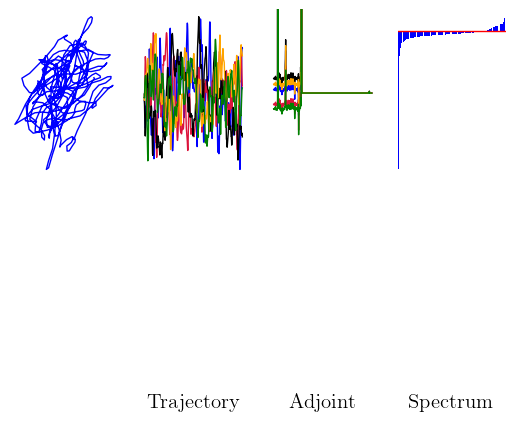

In [18]:
fig, axs = plt.subplots(2, 4)
# [axi.set_axis_off() for axi in axs.ravel()];
[axi.set_xticklabels([]) for axi in axs.ravel()];
[axi.set_yticklabels([]) for axi in axs.ravel()];
[axi.set_xticks([]) for axi in axs.ravel()];
[axi.set_yticks([]) for axi in axs.ravel()];
[axi.spines['top'].set_visible(False) for axi in axs.ravel()];
[axi.spines['left'].set_visible(False) for axi in axs.ravel()];
[axi.spines['right'].set_visible(False) for axi in axs.ravel()];
[axi.spines['bottom'].set_visible(False) for axi in axs.ravel()];
# [axi.get_xaxis().set_visible(False) for axi in axs.ravel()];
# [axi.get_yaxis().set_visible(False) for axi in axs.ravel()];
# [axi.set_frame_on(False) for axi in axs.ravel()];

[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];

axs[0,0].plot(sol_chaos[0,:], sol_chaos[4,:])
axs[0,1].plot(sol_chaos[:5,:].T)
axs[0,2].plot(sol_adjoint_chaos[:5,::-1].T)
axs[0,2].set(ylim=(-5,5));
axs[0,3].bar(range(N_chaos), sorted(lyap_spec_chaos))

# axs[0,3].bar(range(N), sorted(np.real(eigenvalues)))
axs[0,3].plot((-N_chaos,2*N_chaos), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_chaos-0.5));

axs[1,0].set_xlabel("")
axs[1,1].set_xlabel("Trajectory")
axs[1,2].set_xlabel("Adjoint")
axs[1,3].set_xlabel("Spectrum")

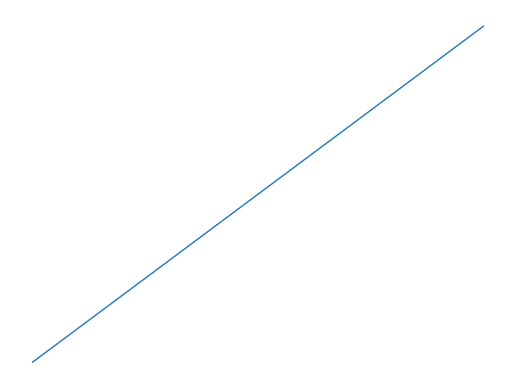

In [19]:
tshift = 50
fig, ax = plt.subplots(1, 1)
ax.set_axis_off()
ax.plot(sol.sol(t)[0,tshift:], sol.sol(t)[4,tshift:])
plt.savefig(currentdir+"/figures/alesiren/chaos_200.pdf", bbox_inches="tight")

### Limit cycle

In [61]:
N_lim = 20
g = 1.8
tau = 10/1000.
mask = np.where(np.random.random((N_lim,N_lim))>0.9,1,0)
W = np.dot(np.random.normal(0,g/np.sqrt(N_lim),(N_lim,N_lim)), mask)
eigenvalues, _ = np.linalg.eig(W-np.eye(N_lim))
b = np.ones(N_lim)*0

In [66]:
t0, t1 = 0, .5
t_lim = np.linspace(t0,t1,500)
y0 = np.random.normal(0,1,N_lim).squeeze()
sol = solve_ivp(tanh_ode, t_span=[t0, t1], t_eval=t_lim, y0=y0, args=([W,b,tau]), dense_output=True)
sol_lim = sol.sol(t_lim)
x_solved = sol.sol
sol_adjoint_lim = solve_ivp(tanh_adj_ode, t_span=[t1, t0], t_eval=t_lim[::-1], y0=y0, args=([W,tau,x_solved]), dense_output=True).sol(t_lim)
lyap_spec_lim = nolds.lyap_e(sol_lim[0,:], emb_dim=N_lim,  matrix_dim=N_lim, tau=tau)

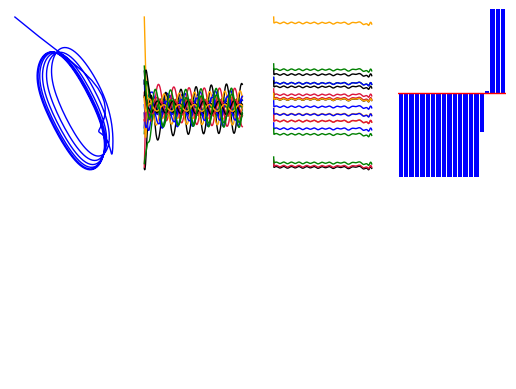

In [67]:
fig, axs = plt.subplots(2, 4)
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];

axs[0,0].plot(sol_lim[0,:], sol_lim[1,:])
axs[0,1].plot(sol_lim[:,:].T)
axs[0,2].plot(sol_adjoint_lim[:,::-1].T)
axs[0,3].bar(range(N_lim), sorted(lyap_spec_lim))
axs[0,3].plot((-N_lim,2*N_lim), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_lim-0.5),ylim=(-1,1));

### Together

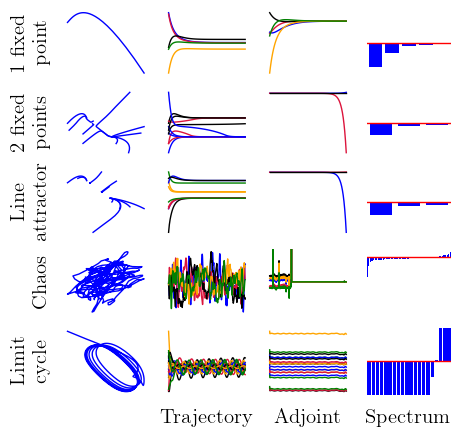

In [68]:
fig, axs = plt.subplots(5, 4, figsize=(5,5))
[axi.set_xticklabels([]) for axi in axs.ravel()];
[axi.set_yticklabels([]) for axi in axs.ravel()];
[axi.set_xticks([]) for axi in axs.ravel()];
[axi.set_yticks([]) for axi in axs.ravel()];
[axi.spines['top'].set_visible(False) for axi in axs.ravel()];
[axi.spines['left'].set_visible(False) for axi in axs.ravel()];
[axi.spines['right'].set_visible(False) for axi in axs.ravel()];
[axi.spines['bottom'].set_visible(False) for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];

axs[0,0].set_ylabel("1 fixed \n point")
axs[0,0].plot(sol_1[0,:], sol_1[4,:])
axs[0,1].plot(sol_1[:,:].T)
axs[0,2].plot(sol_adjoint_1[:,::-1].T)
axs[0,3].bar(range(N_1), lyap_spec_1[::-1])
axs[0,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_1-0.5),ylim=(-1,1));
# axs[0,3].set_yticks([0],[0])

axs[1,0].set_ylabel("2 fixed \n points")
axs[1,1].set_prop_cycle(color=['b', 'crimson', 'k'])
for i in range(sols_2.shape[0]):
    axs[1,0].plot(sols_2[i,0,:], sols_2[i,1,:], 'b')
    axs[1,1].plot(sols_2[i,1,:].T)
axs[1,2].plot(sol_adjoint_2[:,::-1].T)
axs[1,3].bar(range(N_2), lyap_spec_2[::-1])
axs[1,3].plot((-N_2,2*N_2), (0,0), 'r')
axs[1,3].set(xlim=(-.5,N_2-0.5),ylim=(-1,1));

axs[2,0].set_ylabel("Line \n attractor")
for i in range(sols_2.shape[0]):
    axs[2,0].plot(sols_line[i,0,:], sols_line[i,1,:], 'b')
    axs[2,1].plot(sols_line[i,1,:].T)
axs[2,2].plot(sol_adjoint_line[:,::-1].T)
axs[2,3].bar(range(N_2), lyap_spec_2[::-1])
axs[2,3].plot((-N_2,2*N_2), (0,0), 'r')
axs[2,3].set(xlim=(-.5,N_2-0.5),ylim=(-1,1));


axs[3,0].set_ylabel("Chaos")
axs[3,0].plot(sol_chaos[0,:], sol_chaos[4,:])
axs[3,1].plot(sol_chaos[:5,:].T)
axs[3,2].plot(sol_adjoint_chaos[:5,::-1].T)
axs[3,2].set(ylim=(-5,5));
axs[3,3].bar(range(N_chaos), sorted(lyap_spec_chaos))
axs[3,3].plot((-N_chaos,2*N_chaos), (0,0), 'r')
axs[3,3].set(xlim=(-.5,N_chaos-0.5));

axs[4,0].set_ylabel("Limit \n cycle")
axs[4,0].plot(sol_lim[0,:], sol_lim[1,:])
axs[4,1].plot(sol_lim[:,:].T)
axs[4,2].plot(sol_adjoint_lim[:,::-1].T)
axs[4,3].bar(range(N_lim), sorted(lyap_spec_lim))
axs[4,3].plot((-N_lim,2*N_lim), (0,0), 'r')
axs[4,3].set(xlim=(-.5,N_lim-0.5),ylim=(-1,1));

axs[-1,0].set_xlabel("")
axs[-1,1].set_xlabel("Trajectory")
axs[-1,2].set_xlabel("Adjoint")
axs[-1,3].set_xlabel("Spectrum");

plt.savefig(currentdir+"/figures/alesiren/sol_adjoint_spec.pdf", bbox_inches="tight")